In [1]:
# Using https://www.youtube.com/watch?v=eyEabQRBMQA as a reference
# Data is avaible at https://grouplens.org/datasets/movielens/25m/

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing and inspecting data

We start by importing and checking our data.

In [3]:
movies = pd.read_parquet("../data/movies.parquet")
ratings = pd.read_parquet("../data/ratings.parquet")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [8]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [10]:
movies.duplicated().sum()

0

In [11]:
ratings.duplicated().sum()

0

In [12]:
# There are duplicated titles
movies['title'].duplicated().sum()

98

We don't have any nulls or duplicated data. But mind that there are duplicated movies titles.

# Feature extraction

We are going to extract the year from the title of the movie and create genres columns.

In [13]:
# Extracting year from title with regex
movies["year"] = movies['title'].str.extract(r'\((\d{4})\)')

In [14]:
# Creating genres columns
genres = movies['genres'].str.get_dummies('|')

In [15]:
# We could convert the timestamp to datetime to get temporal features

# EDA

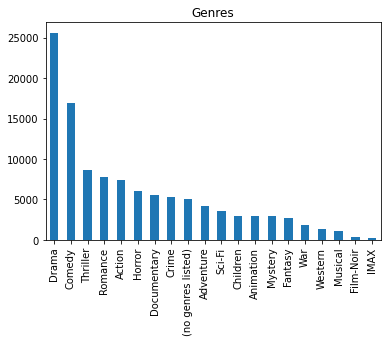

In [16]:
# Most present genres
genres.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Genres')
plt.show()

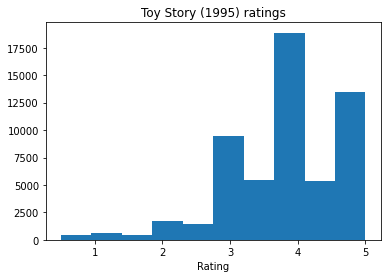

In [17]:
toy_id = movies.loc[movies['title'] == 'Toy Story (1995)', 'movieId'].values[0]
toy_ratings = ratings.loc[ratings['movieId'] == toy_id, 'rating']

plt.hist(toy_ratings)
plt.xlabel('Rating')
plt.title('Toy Story (1995) ratings')
plt.show()

In [18]:
# Ratings count - Top 5% most rated movies

ratings_count = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
ratings_count_norm = ratings_count / ratings_count.sum()
top_5 = ratings_count_norm[ratings_count_norm.cumsum() < 0.05].to_frame()
top_5.merge(right=movies[['movieId', 'title']], left_index=True, right_on='movieId')[['title', 'rating']]

,title,rating
351,Forrest Gump (1994),0.003260
314,"Shawshank Redemption, The (1994)",0.003259
292,Pulp Fiction (1994),0.003187
585,"Silence of the Lambs, The (1991)",0.002965
2480,"Matrix, The (1999)",0.002907
257,Star Wars: Episode IV - A New Hope (1977),0.002749
475,Jurassic Park (1993),0.002566
522,Schindler's List (1993),0.002416
108,Braveheart (1995),0.002367
2867,Fight Club (1999),0.002351


In [19]:
# What's the highest mean rating movie?

# Data processing

In [20]:
# Cleaning titles with regex

import re

def clean(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

movies["clean_titles"] = movies["title"].apply(clean)

In [21]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1, 2))

titles_vec = vec.fit_transform(movies["clean_titles"])

In [22]:
# Refine regex and cleaning

In [23]:
# Consider bigger ngrams

# Search engine

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def search(title):
    title = clean(title)
    query_vec = vec.transform([title])
    similarity = cosine_similarity(query_vec, titles_vec).flatten()
    
    # Selecting top 5 movies
    idx = np.argpartition(similarity, kth=-5)[-5:]

    results = movies.iloc[idx][::-1]
    return results

In [25]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(description="Movie title", value="Toy Story 1995", disabled=False)
movie_output = widgets.Output()

def when_type(data):
    with movie_output:
        movie_output.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(when_type, names='value')

display(movie_input, movie_output)

Text(value='Toy Story 1995', description='Movie title')

Output()

# Recomendation systems

## Non-personalized recomendations

### High rate/watch movies

In [26]:
# Movies with more than 500 reviews

review_count = ratings["movieId"].value_counts()
pop_movies = review_count[review_count > 3000].index

In [27]:
# Best reviewed movies

pop_movies_ratings = ratings[ratings["movieId"].isin(pop_movies)]
movie_rec = pop_movies_ratings[["rating", "movieId"]].groupby("movieId").mean().sort_values(by="rating", 
                                                                           ascending=False).reset_index()


In [28]:
movie_rec.merge(right=movies[["movieId", "title"]], on="movieId").head(10)

,movieId,rating,title
0,318,4.413576,"Shawshank Redemption, The (1994)"
1,858,4.324336,"Godfather, The (1972)"
2,50,4.284353,"Usual Suspects, The (1995)"
3,1221,4.261759,"Godfather: Part II, The (1974)"
4,2019,4.254769,Seven Samurai (Shichinin no samurai) (1954)
5,527,4.247579,Schindler's List (1993)
6,1203,4.243014,12 Angry Men (1957)
7,904,4.237948,Rear Window (1954)
8,2959,4.228311,Fight Club (1999)
9,1193,4.218662,One Flew Over the Cuckoo's Nest (1975)


### Most seem together

In [29]:
# from itertools import permutations

# def create_pairs(x):
#     pairs = pd.DataFrame(list(permutations(x.values, 2)), columns=["movie_a", "movie_b"])
#     return pairs

# # Getting a smaller sample from ratings
# n_users = 1000
# selected_users = ratings['userId'].sample(n_users, replace=False).values
# small_ratings = ratings.loc[ratings["userId"].isin(selected_users), ["userId", "movieId"]]

# # Get a smaller movie subset
# small_ratings_count = small_ratings["movieId"].value_counts()
# small_ratings_count = small_ratings_count[small_ratings_count > 250]
# smaller_ratings = small_ratings[small_ratings["movieId"].isin(small_ratings_count.index)]

# # Counting the pairs movies watched by the same user
# pair_counts = smaller_ratings.groupby("userId")["movieId"].apply(create_pairs).reset_index(drop=True)

# # Saving the results
# pair_counts.to_parquet("../data/pair_counts.parquet")

In [30]:
pair_counts = pd.read_parquet("../data/pair_counts.parquet")

In [31]:
pair_counts = pair_counts.groupby(["movie_a", "movie_b"]).size().to_frame(name='size').reset_index()

In [32]:
pair_counts_a = pair_counts.merge(right=movies[["movieId", "title"]], left_on="movie_a", right_on="movieId")[["title", "movie_b", "size"]]
pair_counts_a = pair_counts_a.rename(columns={"title":"movie_a"})

In [33]:
pair_counts_b = pair_counts_a.merge(right=movies[["movieId", "title"]], left_on="movie_b", right_on="movieId")[["movie_a", "title", "size"]]
pair_counts = pair_counts_b.rename(columns={"title":"movie_b"})
pair_counts.head()

,movie_a,movie_b,size
0,Toy Story (1995),Jumanji (1995),290
1,Heat (1995),Jumanji (1995),167
2,GoldenEye (1995),Jumanji (1995),185
3,Casino (1995),Jumanji (1995),154
4,Ace Ventura: When Nature Calls (1995),Jumanji (1995),194


In [34]:
pair_counts[pair_counts["movie_a"] == "Toy Story (1995)"].sort_values(by="size", ascending=False).head(10)

,movie_a,movie_b,size
10624,Toy Story (1995),Forrest Gump (1994),500
8632,Toy Story (1995),Pulp Fiction (1994),472
61420,Toy Story (1995),"Matrix, The (1999)",469
7304,Toy Story (1995),Star Wars: Episode IV - A New Hope (1977),467
13944,Toy Story (1995),Jurassic Park (1993),465
18260,Toy Story (1995),"Silence of the Lambs, The (1991)",465
9296,Toy Story (1995),"Shawshank Redemption, The (1994)",458
37848,Toy Story (1995),Back to the Future (1985),458
30212,Toy Story (1995),Raiders of the Lost Ark (Indiana Jones and the...,443
32536,Toy Story (1995),Star Wars: Episode VI - Return of the Jedi (1983),438


### Content-based recommendation

In [73]:
movies_and_genres = movies[['movieId']].join(genres).set_index('movieId')

In [102]:
from sklearn.metrics import jaccard_score

def get_similarities(movieId):
    movie_row = movies_and_genres.loc[movieId]
    movies_and_genres['similarities'] = movies_and_genres.apply(lambda x: jaccard_score(movie_row, x), axis=1)
    return movies_and_genres.sort_values(by='similarities', ascending=False)

movies_similarities = get_similarities(1)

In [111]:
movies_similarities.head(10).join(movies.set_index('movieId'))[['title', 'genres']]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
177037,Puss in Book: Trapped in an Epic Tale (2017),Adventure|Animation|Children|Comedy|Fantasy
175625,The Dragon Spell (2016),Adventure|Animation|Children|Comedy|Fantasy
136016,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy
136361,Scooby-Doo! Mask of the Blue Falcon (2012),Adventure|Animation|Children|Comedy|Fantasy
4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
186159,Tangled: Before Ever After (2017),Adventure|Animation|Children|Comedy|Fantasy
186177,Trolls Holiday (2017),Adventure|Animation|Children|Comedy|Fantasy
196693,Dragons: Dawn Of The Dragon Racers (2014),Adventure|Animation|Children|Comedy|Fantasy


## Colaborative filtering

In [181]:
movie_id = 1

# Users that watched our movie and rated >4
similar_users = ratings.loc[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4.0), "userId"].unique()

# High rated movies (>4) that our similiar users watched
similar_users_rec = ratings.loc[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.0), "movieId"]

# Counting how many users watched our recomendation. Getting the percentage from similar users
similar_rec_movies_percentage = (similar_users_rec.value_counts() / len(similar_users))

# Restricting ourselves to 10%
similar_rec_movies_percentage = similar_rec_movies_percentage[similar_rec_movies_percentage > 0.1]

In [198]:
similar_rec_movies_percentage

1        1.000000
318      0.445607
260      0.403770
356      0.370215
296      0.367295
           ...   
953      0.103053
551      0.101195
1222     0.100876
745      0.100345
48780    0.100186
Name: movieId, Length: 113, dtype: float64

In [199]:
# We don't want movies that are there just because they are already popular

all_users = ratings.loc[(ratings["movieId"].isin(similar_rec_movies_percentage.index)&(ratings["rating"]>4.0))]
all_users_recs_percentage = all_users["movieId"].value_counts() / len(all_users["userId"].unique())

In [200]:
all_users_recs_percentage

318      0.342220
296      0.284674
2571     0.244033
356      0.235266
593      0.225909
           ...   
551      0.040918
50872    0.039111
745      0.037031
78499    0.035131
2355     0.025091
Name: movieId, Length: 113, dtype: float64

In [210]:
# Creating a score

rec_percentages = pd.concat([similar_rec_movies_percentage, all_users_recs_percentage], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
rec_percentages = rec_percentages.sort_values("score", ascending=False).iloc[:9].merge(movies, left_index=True, right_on="movieId")

In [211]:
rec_percentages

,similar,all,score,movieId,title,genres,clean_titles
0,1.000000,0.124728,8.017414,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
3021,0.280648,0.053706,5.225654,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 2 1999
2264,0.110539,0.025091,4.405452,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,Bugs Life A 1998
14813,0.152960,0.035131,4.354038,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,Toy Story 3 2010
4780,0.235147,0.070811,3.320783,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,Monsters Inc 2001
580,0.216618,0.067513,3.208539,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,Aladdin 1992
6258,0.228139,0.072268,3.156862,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,Finding Nemo 2003
587,0.179400,0.059977,2.991150,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,Beauty and the Beast 1991
8246,0.203504,0.068453,2.972889,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,Incredibles The 2004


In [ ]:
# KMeans: Genres, year, mean rating, number of ratings